In [ ]:
#!pip install numpy
#!pip install matplotlib
#!pip install scipy 
#!pip install pandastable
#!pip install sympy
#!pip install math

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import pandas as pd
import csv
import sympy
from sympy import integrate, log, exp, oo
from sympy.abc import a, x, y
from scipy.interpolate import interp1d

import tkinter as tk
from tkinter import filedialog as fd

root = tk.Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

''

# User Input Files

Running the following block of code will initiate a request for user data. Please select, in order:
##### 1: AM1.5G Data
 
Column 1: wavelength (nm)

Column 2+: irradiance per meter squared per nanometer

##### 2:  Water  Attenuance Data  (Jenkins, Morel, Misha, etc)
  
Column 1: wavelength (wl)

Column 2: alpha


In [2]:
dfam15g = fd.askopenfilename()
dfalpha = fd.askopenfilename()
xnew = np.linspace(300,1100, num=801) #range you'd like to focus on 
depth_range = 3   #If depth_range is 3, then it will provide data for the underwater spectrum at 1,2, and 3 m. 
                  #This number can be changed to however many meters below sealevel. 

# Beer's Law

Beer-Lambert's correction law can be applied where $\alpha $ is attenuated water spectra and $\delta$  is depth. This is how $E_{UW}$ or the underwater spectra that you would like to simulate your test cell under will be determined. 

\begin{equation}  \epsilon_{UW} (λ,D)  = \epsilon_{AM1.5G} (λ)*  e^{\alpha (λ) D} \end{equation}


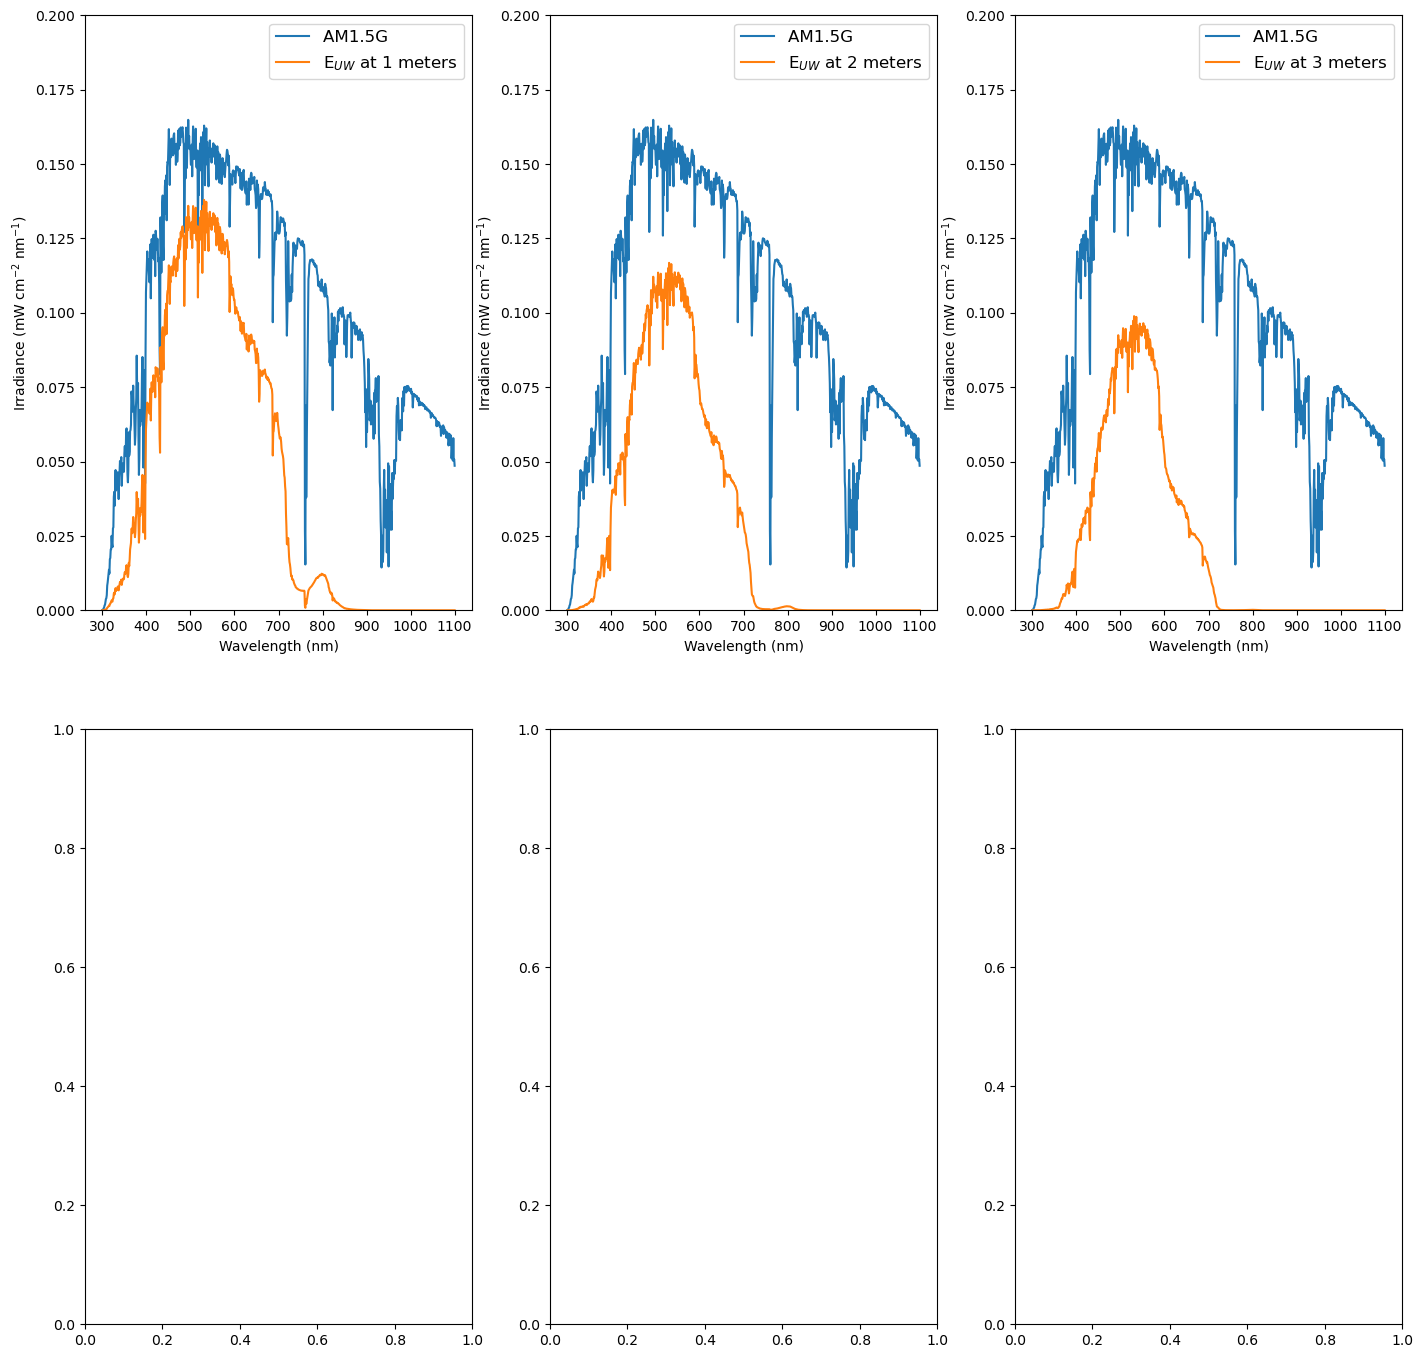

In [3]:
#----------------------------------------------Load AM1.5G Data---------------------------------------
A = pd.read_csv(dfam15g)
x = A['wl (nm)']
y = A['ir (W m-2 nm-1)'] *.1  #changing units to mW cm-2 nm-1)

#--------------------------------------------Interpolation Step---------------------------------------
f = interp1d(x, y)
f2 = interp1d(x, y, kind='linear')

X = xnew
Y = f(xnew)

dfa = pd.DataFrame(Y,X, columns=['AM 1.5 Irradiance (mW cm-2 nm-1)'])

#-------------------------------Load Water Attenuated Water Absorption Data---------------------------
B = pd.read_csv(dfalpha)
xalpha = B['wl']
yalpha = B['alpha']

#--------------------------------------------Interpolation Step---------------------------------------
falpha1 = interp1d(xalpha, yalpha)
falpha2= interp1d(xalpha, yalpha, kind='linear')

Xalpha = xnew
Yalpha= falpha1(xnew)

dfalpha = pd.DataFrame(Yalpha,Xalpha, columns=['Alpha'])
dfa = pd.concat([dfa,dfalpha], axis = 1)

#----------------------------Calculating E_uw--------------------------------------------------------
depthplt, axs = plt.subplots(depth_range // 3 + 1, 3, figsize=(17, 17))
for depth in range(1, depth_range+1):    
    Enew = pd.DataFrame([])
    Enew["Euw"] = dfa["AM 1.5 Irradiance (mW cm-2 nm-1)"] * (np.exp(-dfa["Alpha"] * depth))

    yI = Enew["Euw"]
    
    row = (depth-1) // 3
    column = (depth-1) % 3
 
    axs[row, column].plot(xnew, f(xnew))
    axs[row, column].plot(xnew, yI)
    axs[row, column].legend(["AM1.5G ", "E$_{UW}$ at %s meters" % depth], loc ="upper right", prop={'size': 12})

    axs[row, column].set_xlabel("Wavelength (nm)")
    axs[row, column].set_ylabel("Irradiance (mW cm$^{-2}$ nm$^{-1}$)")
    axs[row, column].set_ylim([0, 0.2])
plt.show()